In [7]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
import os

folder_path = '/Users/evanschwartz/Desktop/DataAllHaveImages.csv'
df = pd.read_csv(folder_path)
X = []
y = []
thumbnails_dir = '/Users/evanschwartz/Desktop/thumbnails-jpegs'

for img in os.listdir(thumbnails_dir):
    img_path = os.path.join(thumbnails_dir, img)
    loc = df.loc[df['Id'] == img[:-4]] ## locates the matching ids for images and corresponding feature in csv
    if loc.empty:                      ## as some of our data has no matching ids, just skip and remove the data
        os.remove(img_path)
    else:
        y.append(np.float32(np.asarray(loc['View Count'])[0]))  ## append target variable y for view count
        thumb = load_img(img_path)
        thumb_256 = thumb.resize((256,256))         ## resize all images to 256 x 256, easier to work with in Conv2d
        X.append(np.asarray(thumb_256))             ## append all images as arrays to X
        
assert(len(y) == len(X))       


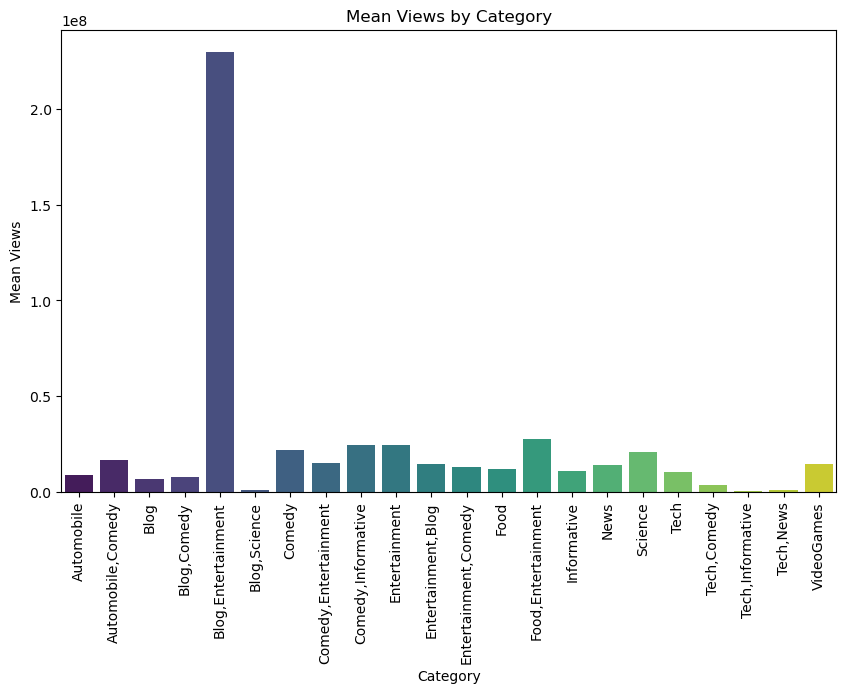

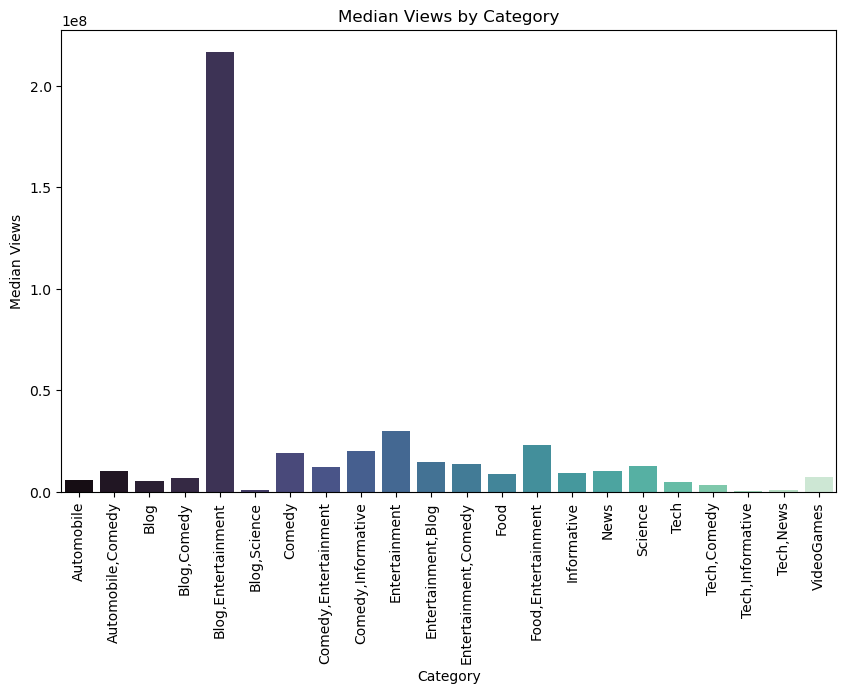

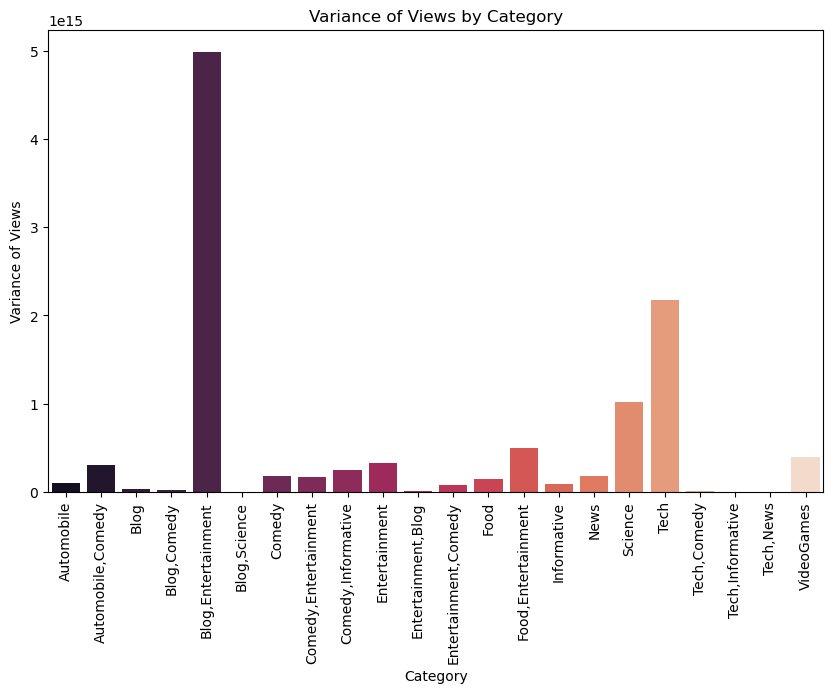

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns


grouped_stats = df.groupby('Category')['View Count'].agg(['mean', 'median', 'var']).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='mean', data=grouped_stats, palette='viridis')
plt.title('Mean Views by Category')
plt.xlabel('Category')
plt.ylabel('Mean Views')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='median', data=grouped_stats, palette='mako')
plt.title('Median Views by Category')
plt.xlabel('Category')
plt.ylabel('Median Views')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='var', data=grouped_stats, palette='rocket')
plt.title('Variance of Views by Category')
plt.xlabel('Category')
plt.ylabel('Variance of Views')
plt.xticks(rotation=90)
plt.show()

2297


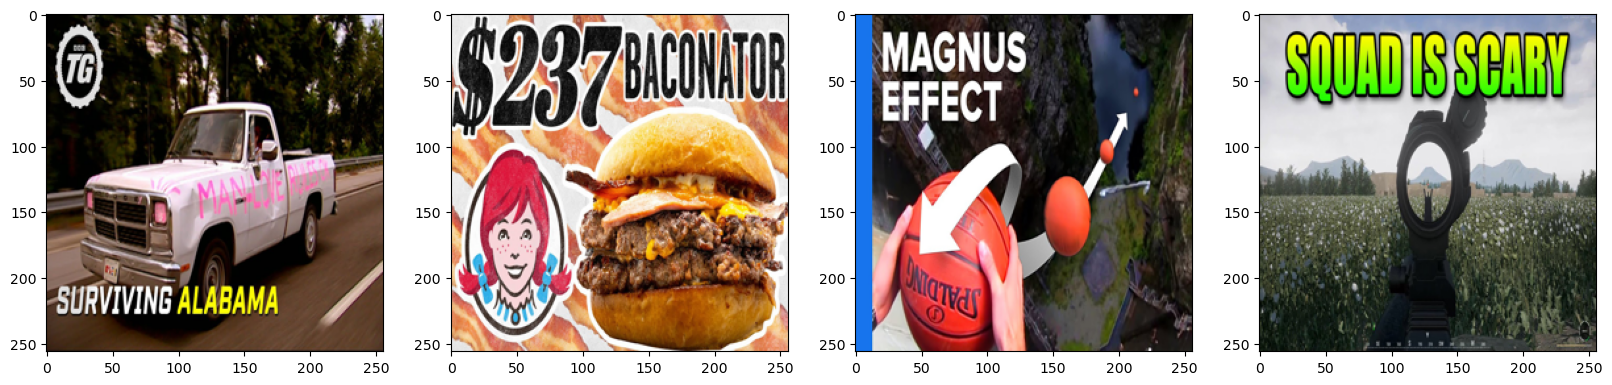

In [18]:
from matplotlib import pyplot as plt
print(len(X))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#print 5 thumbnails to verify tf.data works
for i in range(4):
    ax[i].imshow(X[i].astype(int))

In [37]:
# Normalize target values using MinMaxScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(np.reshape(y, (-1, 1)))

# Text Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles)
title_sequences = tokenizer.texts_to_sequences(titles)
title_sequences_padded = pad_sequences(title_sequences, maxlen=30)

# One-hot encoding
categories_one_hot = pd.get_dummies(df['Category'])
categories_one_hot_array = categories_one_hot.values

#Cast to array 
X_array = np.array(X)

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_array, title_sequences_padded, categories_one_hot_array, y))

# Define batch size
batch_size = 32

# Batch the dataset
dataset = dataset.batch(batch_size)

# Map function to normalize features
dataset = dataset.map(lambda x, title, cat, y: (tf.cast(x/255, tf.float32), title, cat, y))

In [39]:
print(X_array.shape)

(2297, 256, 256, 3)


In [40]:
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.2)
test_size = int(len(dataset) * 0.1)

print(len(dataset))
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)

# Shuffle the dataset
dataset_shuffled = dataset.shuffle(len(dataset), seed=42)

# Split the dataset
train_dataset = dataset_shuffled.take(train_size).batch(32)
val_dataset = dataset_shuffled.skip(train_size).take(val_size).batch(32)
test_dataset = dataset_shuffled.skip(train_size + val_size).take(test_size).batch(32)

72
Train Size: 50
Validation Size: 14
Test Size: 7


In [62]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
image_input = Input(shape=(256, 256, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
maxpool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(maxpool2)
cnn_output = Dense(128, activation='relu')(flatten)

category_input = Input(shape=(categories_one_hot_array.shape[1],), name='category_input')
category_dense = Dense(64, activation='relu')(category_input)

merged = concatenate([cnn_output, category_dense])

dense1 = Dense(128, activation='relu')(merged)
dropout1 = Dropout(0.5)(dense1)  # Dropout layer with 0.5 dropout rate

dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)  # Dropout layer with 0.5 dropout rate

# Output layer for regression
output = Dense(1, activation='linear')(dropout2)

# Create model
model = Model(inputs=[image_input, category_input], outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Prepare the datasets
def prepare_dataset(dataset):
    def _prepare_data(image, title, category, label):
        return {'image_input': image, 'category_input': category}, label
    return dataset.map(_prepare_data)

train_prepared = prepare_dataset(train)
validate_prepared = prepare_dataset(validate)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_prepared,
    validation_data=validate_prepared,
    epochs=5,
    batch_size=32,
    callbacks = [early_stop]
)

# Print model summary
model.summary()


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 6.2138 - mae: 1.0621 - val_loss: 0.0037 - val_mae: 0.0296
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 0.0047 - mae: 0.0433 - val_loss: 0.0033 - val_mae: 0.0238
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.0043 - mae: 0.0374 - val_loss: 0.0032 - val_mae: 0.0223
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 0.0034 - mae: 0.0318 - val_loss: 0.0032 - val_mae: 0.0214
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.0033 - mae: 0.0292 - val_loss: 0.0032 - val_mae: 0.0209


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 254, 254,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 127, 127,  │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 125, 125,  │     18,496 │ max_pooling2d_24… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 62, 62,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 246016)    │          0 │ max_pooling2d_25… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 128)       │ 31,490,176 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 64)        │      1,472 │ category_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 192)       │          0 │ dense_60[0][0],   │
│ (Concatenate)       │                   │            │ dense_61[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 128)       │     24,704 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_62[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 64)        │      8,256 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 64)        │          0 │ dense_63[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 1)         │         65 │ dropout_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 94,632,197 (360.99 MB)

 Trainable params: 31,544,065 (120.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,088,132 (240.66 MB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - loss: 0.0110 - mae: 0.0288
Test Loss: 0.007980202324688435, Test MAE: 0.02667948789894581


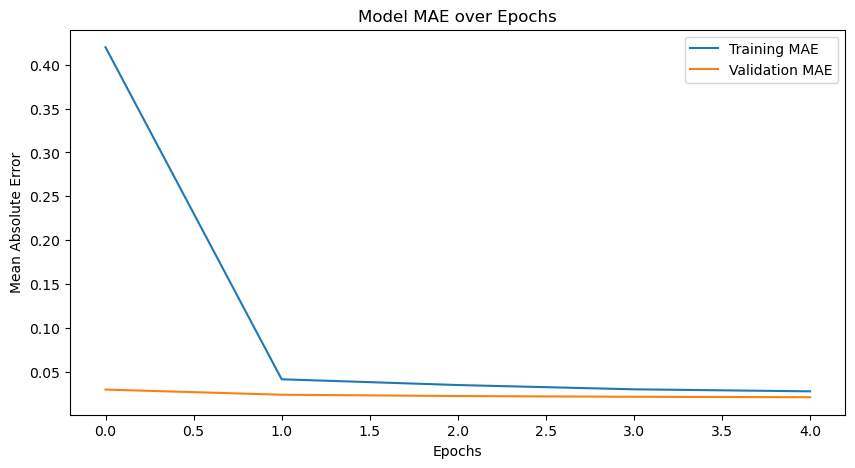

In [63]:
test_prepared = prepare_dataset(test)

test_loss, test_mae = model.evaluate(test_prepared)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')

plt.title('Model MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.show()